In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.models import load_model
import keras.backend as K

import cv2

from skimage.morphology import skeletonize

from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

from patchify import patchify, unpatchify

from skimage.morphology import remove_small_objects

import networkx as nx

import glob

2024-01-19 15:28:39.181875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 15:28:39.181923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 15:28:39.182902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 15:28:39.189039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(path, type):

    file_list = os.listdir(path)
    images = []

    for filename in file_list:
        if filename.endswith(type):
            input_image_path = os.path.join(path, filename)
            input_image = cv2.imread(input_image_path, 0)
            images.append(input_image)
    
    return images

In [3]:
def roi_image(input_im):

    if len(input_im.shape) == 3 and input_im.shape[2] == 3:
        im_gray = cv2.cvtColor(input_im, cv2.COLOR_BGR2GRAY)
    elif len(input_im.shape) == 2:
        # If the input image is already grayscale, no need to convert
        im_gray = input_im
    else:
        # Handle other cases (e.g., images with more than 3 channels)
        raise ValueError("Unsupported number of channels in input image")

    kernel = np.ones((50, 50), dtype="uint8")

    im_e = cv2.dilate(im_gray, kernel, iterations=1)
    im_closing = cv2.erode(im_e, kernel, iterations=1)

    th, output_im = cv2.threshold(im_closing, 160, 255, cv2.THRESH_BINARY)

    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    area_of_interest = None
    largest_area = 0

    for i in range(1, len(stats)):
        x, y, w, h, area = stats[i]
        if area > largest_area:
            largest_area = area
            area_of_interest = (x, y, w, h)

    x, y, w, h = area_of_interest

    image = cv2.rectangle(input_im, (x, y), (x+w, y+h), (0, 0, 255), 2)

    roi = input_im[y:y+h, x:x+w]
    return roi, y, h, x, w

In [4]:
def preprocess_data(images, masks, patch_size):
    images_list = []
    masks_list = []

    for image, mask in zip(images, masks):
        # Apply ROI to both image and mask

        _, y, h, x, w = roi_image(image)
        
        image_roi = image[y:y+h, x:x+w]
        mask_roi = mask[y:y+h, x:x+w]

        # Perform additional processing as needed
        image_roi = padder(image_roi, patch_size)
        mask_roi = padder(mask_roi, patch_size)

        # Patchify the processed image and mask
        image_patches = patchify(image_roi, (patch_size, patch_size), step=patch_size)
        mask_patches = patchify(mask_roi, (patch_size, patch_size), step=patch_size)

        # Reshape the patches
        image_patches = image_patches.reshape(-1, patch_size, patch_size, 1)
        mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

        images_list.append(image_patches)
        masks_list.append(mask_patches)

    X = np.array(images_list)
    y = np.array(masks_list)

    # Reshape the arrays
    X = X.reshape(-1, patch_size, patch_size, 1)
    y = y.reshape(-1, patch_size, patch_size, 1)

    # Normalize the image data
    X = X / 255.0

    return X, y

In [5]:
def padder(image, patch_size):

    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [6]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [7]:
def predict_all(images, patch_size):

    predictions = []

    for image in images:
    
        image, _, _, _, _ = roi_image(image)
        image = padder(image, patch_size)
        
        patches = patchify(image, (patch_size, patch_size), step=patch_size)
        
        i = patches.shape[0]
        j = patches.shape[1]
        
        patches = patches.reshape(-1, patch_size, patch_size, 1)
        
        preds = model.predict(patches/255)
        
        preds_reshaped = preds.reshape(i, j, patch_size, patch_size)
        
        predicted_mask = unpatchify(preds_reshaped, (i*patch_size, j*patch_size))

        predictions.append(predicted_mask)

    return predictions

In [8]:
def highlight_top_objects(image, prediction, index, num_objects=5):
    
    if index == 6:
            image = image[250:600, 300:2600]
            prediction = prediction[250:600, 300:2600]
    
    def sort_objects_by_area(stats):
        areas = [stat[-1] for stat in stats[1:]]
        sorted_areas = sorted(enumerate(areas, start=1), key=lambda x: x[1], reverse=True)
        return sorted_areas

    def extract_and_highlight_objects(image, prediction, sorted_areas, num_objects):
        plants = []
        plants_pred = []
        x_coordinates = []
    
        for i in range(1, num_objects + 1):
            index, area = sorted_areas[i - 1]
            x, y, w, h, _ = stats[index]
    
            x_coordinates.append(x)
    
            cropped_roi_pred = prediction[y:y + h, x:x + w]
            cropped_roi = image[y:y + h, x:x + w]
    
            plants.append(cropped_roi)
            plants_pred.append(cropped_roi_pred)
    
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
            prediction = cv2.rectangle(prediction, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
        # Sort based on X coordinates
        sorted_indices = np.argsort(x_coordinates)
        sorted_plants = [plants[i] for i in sorted_indices]
        sorted_plants_pred = [plants_pred[i] for i in sorted_indices]
    
        return image, prediction, sorted_plants, sorted_plants_pred

    pred = cv2.convertScaleAbs(prediction)

    _, _, stats, _ = cv2.connectedComponentsWithStats(pred)

    sorted_areas = sort_objects_by_area(stats)

    num_objects = min(num_objects, len(stats) - 1)

    result_image, result_pred, highlighted_plants, highlighted_plants_pred = extract_and_highlight_objects(
        image, prediction, sorted_areas, num_objects
    )

    return result_image, result_pred, highlighted_plants, highlighted_plants_pred

In [9]:
def find_end_node(graph):
 
    src = list(graph['node-id-src'])
    end_nodes = []
    for destination in list(graph['node-id-dst']):
        if destination not in src:
            end_nodes.append(destination)
    return end_nodes

In [10]:
def filter_most_common_number(df, column_name):

    most_common_number = df[column_name].mode().values[0]
    
    filtered_df = df[df[column_name] == most_common_number]

    return filtered_df

In [11]:
def get_nodes(object):

    skeleton = skeletonize(object>0.5)
    summary = summarize(Skeleton(skeleton))
    end_nodes = find_end_node(summary)
    summary = filter_most_common_number(summary, 'skeleton-id')

    return summary

In [12]:
def visualise_landmarks(object, nodes):
    plt.imshow(object, cmap='gray')

    start_nodes = list(nodes['node-id-src'])
    end_nodes = find_end_node(nodes)

    min_index = nodes['node-id-src'].idxmin()
    min_value_column1 = nodes.loc[min_index, 'image-coord-src-0']
    min_value_column2 = nodes.loc[min_index, 'image-coord-src-1']

    for node in start_nodes:
        node_info = nodes[nodes['node-id-src'] == node]
        x_start, y_start = node_info['image-coord-src-1'], node_info['image-coord-src-0']

        plt.scatter(x_start, y_start, color='blue')

        # Check if any of the points are equal to the minimum index
        if (x_start == min_value_column2).any():
            plt.scatter(min_value_column2, min_value_column1, color='green')

    max_index = nodes['node-id-dst'].idxmax()
    max_value_column1 = nodes.loc[max_index, 'image-coord-dst-0']
    corresponding_value_column2 = nodes.loc[max_index, 'image-coord-dst-1']

    for node in end_nodes:
        node_info = nodes[nodes['node-id-dst'] == node]
        x_end, y_end = node_info['image-coord-dst-1'], node_info['image-coord-dst-0']

        plt.scatter(x_end, y_end, color='red')

        # Check if any of the points are equal to the maximum index
        if (x_end == corresponding_value_column2).any():
            plt.scatter(corresponding_value_column2, max_value_column1, color='black')

    plt.show()

In [13]:
path = 'kaggle_data'

Putting the images in the correct order, since it can help for improving on the leaderboard

In [14]:
# Get a list of file paths matching the pattern (e.g., '*.tif') using glob
file_path = glob.glob(path + '/*.tif')
 
# Define a custom sorting function to extract numeric values from filenames
def extract_numeric_value(filename):
    # Extract the numeric part from the filename (e.g., "test_image_1.tif" -> 1)
    numeric_part = int(filename.split('_')[-1].split('.')[0])
    return numeric_part
 
# Sort the list of file paths based on the numeric values extracted from filenames
file_paths = sorted(file_path, key=extract_numeric_value)

Loading the images

In [15]:
images_test = []

for path in file_paths:
    image = cv2.imread(path, 0)
    images_test.append(image)

Loading the model, so it can be used for predicting

In [16]:
model = load_model('root_model.h5', custom_objects={'f1':f1, 'iou':iou})

2024-01-19 15:28:43.425929: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-19 15:28:43.426227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7956 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-01-19 15:28:43.426638: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-19 15:28:43.426928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1282 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-01-19 15:28:43.427232: W tensorflow/core/common_runti

Defining the patch size for further actions

In [17]:
patch_size = 256

Predicting the images

In [18]:
predictions = predict_all(images_test, patch_size)

2024-01-19 15:28:44.840648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


4/4 [==============================] - 0s 23ms/step


Impelemting the roi_image and padder to make the test image more competible for the code

In [19]:
roi_images = []

for image in images_test:
    new_im, _, _, _, _ = roi_image(image)
    new_im = padder(new_im, patch_size)
    roi_images.append(new_im)

Creating variable with 1 image for each test image and predictions, so I can test them

In [20]:
index = 0

test_image = roi_images[index]
test_pred = predictions[index]

This function does:
- Sorts the cropped plants from left to right;
- Put bounding boxes on the object in the image;
- Extract the plants as separated images (for both test images and prediction)

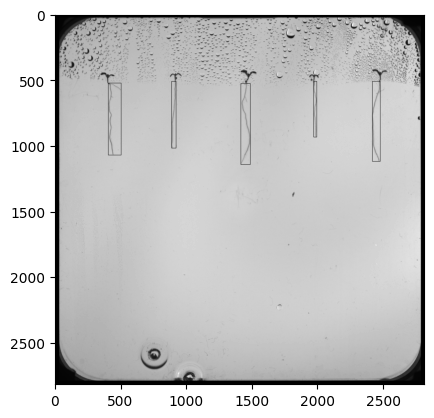

In [21]:
test_image, test_pred, plants, plants_pred = highlight_top_objects(test_image, test_pred, index=index)

plt.imshow(test_image, cmap='gray')

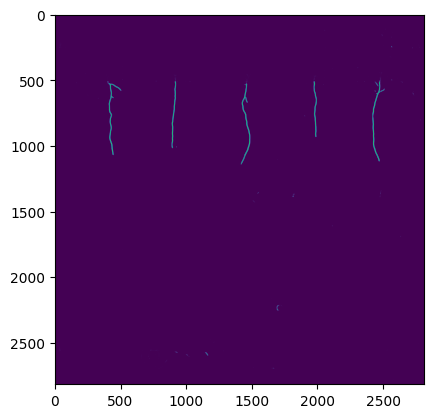

In [22]:
plt.imshow(test_pred)

Using the nodes and visualise_landmarks function to check whether the nodes are put on the correct locations:
- green is the top of the primary root;
- blues are the junctions;
- red the lateral root tips;
- black the primary root tips

Additionaly, it was added the checker list to collect all the nodes dataframes, so they can be checked if there is something wrong

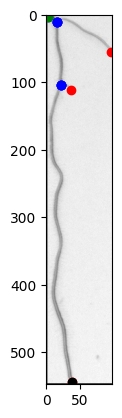

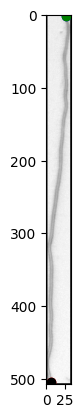

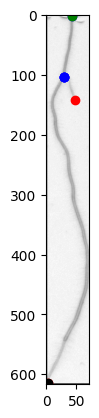

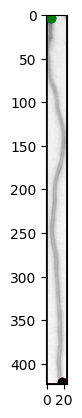

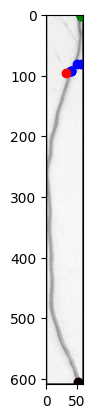

In [23]:
checker = []
for plant_pred, plant in zip(plants_pred, plants):
    nodes = get_nodes(plant_pred)
    checker.append(nodes)
    visualise_landmarks(plant, nodes)

In [24]:
checker[2]

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,103,106.970563,1,1.0,0.0,2,42,104,30,2,42,104,30,102.703457
1,0,103,655,569.404112,1,1.0,0.0,104,30,614,2,104,30,614,2,510.768049
2,0,103,183,47.798990,1,1.0,0.0,104,30,142,48,104,30,142,48,42.047592


Checking the skeletons if there is something wrong with them.

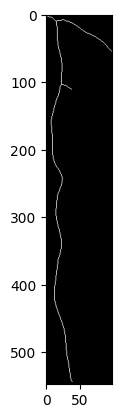

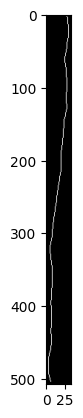

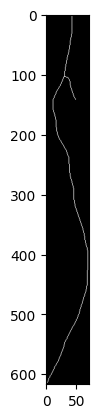

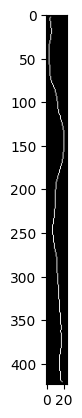

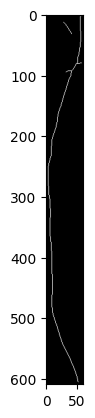

In [25]:
for plant_pred in plants_pred:
    skeleton = skeletonize(plant_pred>0.5)
    plt.imshow(skeleton, cmap='gray')
    plt.show()

In [26]:
checker[2]

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,103,106.970563,1,1.0,0.0,2,42,104,30,2,42,104,30,102.703457
1,0,103,655,569.404112,1,1.0,0.0,104,30,614,2,104,30,614,2,510.768049
2,0,103,183,47.798990,1,1.0,0.0,104,30,142,48,104,30,142,48,42.047592


In the cell below are collected the distances between the top of the primary root to the tip:

In [27]:
data = []

for i, (image, pred) in enumerate(zip(images_test, predictions)): # Iterating through all the images
    test_image, test_pred, plants, plants_pred = highlight_top_objects(image, pred, index=i) # Taking the cropt plants (both predicted image and plants)

    for j, (plant, plant_pred) in enumerate(zip(plants, plants_pred)): # Iterating through the cropped objects
        if (i == 5) or (i == 10 and j == 2) or (i == 8 and j == 2): # if index equal to one of this, puts 0s, because the roots cannot be detected
            primary_root = 0
        elif (i == 6 and j == 0): # in this case the root can be detected by the boundary box, but not the skeleton - that's why 1
            primary_root = 1
        else:
            nodes = get_nodes(plant_pred) # Taking the nodes of skeleton
            G = nx.from_pandas_edgelist(nodes, source='node-id-src', target='node-id-dst', edge_attr='branch-distance') # converting to edgelist
            all_nodes = list(G.nodes()) # checking the nodes
            print(all_nodes)
            first_node = all_nodes[0] # setting the first node
            if i == 0 and j == 2: # setting the last node for a specific example
                last_node = all_nodes[2]
            else:
                last_node = all_nodes[-1] # setting the last node for the other images
            primary_root = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance') # calculating the shortest distance from the top to the tip

        output_name = f"test_image_{i + 1}_plant_{j + 1}" # setting a name for the plant

        data.append({'Plant ID': output_name, 'Length (px)': primary_root}) # Adding it to the list 

    print(i+1)

result_df = pd.concat([pd.DataFrame(data[i:i+1]) for i in range(len(data))], ignore_index=True) # converting to dataframe

[0, 23, 135, 185, 207, 640]
[0, 499]
[0, 100, 651, 180]
[0, 417]
[0, 100, 98, 122, 126, 638]
1
[5, 173, 27, 195, 440, 989, 955, 839, 1209, 1214, 1376, 1294, 1982, 1552, 2344, 2218, 2529, 2719, 2892, 3004]
[0, 100, 116, 450, 1086, 637, 1797, 645, 2181, 1808]
[1, 34, 276, 198, 357, 524, 677, 1071, 1600, 1618, 1715, 1703, 1744, 2014]
[0, 114, 419, 458, 468, 1385]
[0, 18, 87, 71, 607, 336, 739, 674, 692, 1210, 1410, 1606, 1726, 1668, 1907, 1864, 1935, 1957, 2025, 2016, 2536, 2331, 2692, 2607]
2
[0, 68, 92, 684]
[3, 173, 270, 751, 1167, 1260, 1257, 1829, 1832, 1836, 1830, 1849]
[0, 30, 33, 84, 437, 231, 638, 1742]
[100, 332, 280, 367, 467, 514, 978, 1984]
[1, 9, 12, 196, 1092, 340, 560, 1043, 934, 1453, 1550, 1213, 1191, 1386, 1551, 2412]
3
[0, 23, 710, 238, 1532, 1001]
[0, 219, 23, 57, 228, 492, 932, 371, 1101, 553, 520, 1168, 846, 1184, 1224, 1336, 1346, 1518, 1980, 1521]
[24, 134, 80, 118, 1002, 137]
[0, 29, 147, 1000]
[0, 8, 70, 78, 123, 163, 191, 417, 420, 1026]
4
[0, 30, 982, 252, 629

In [28]:
result_df

,Plant ID,Length (px)
0,test_image_1_plant_1,585.421356
1,test_image_1_plant_2,518.468037
2,test_image_1_plant_3,671.546248
3,test_image_1_plant_4,436.882251
4,test_image_1_plant_5,645.492424
5,test_image_2_plant_1,1129.452886
6,test_image_2_plant_2,1228.068109
7,test_image_2_plant_3,1259.688384
8,test_image_2_plant_4,1282.901587
9,test_image_2_plant_5,1022.404112


In [29]:
result_df.to_csv('output.csv', index=False) # Converting to csv